### Imports

In [43]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

### Graphs

In [44]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Input Pipeline

In [45]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print(train_dataset.element_spec)

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2024-10-05 00:51:29.591959: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [46]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [47]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [48]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'As gently as I can, I sincerely believe this movie is a waste of time. I did not find it the \'warm, emotionally satisfying\' film others did. I found it boring, with music that distracted from the film. The story was thin, the characters overdrawn, and the direction pedestrian.<br /><br />Fooey.<br /><br />Now I\'m going to write some more about this movie, so I make the 10 line minimum. There really isn\'t more to be said and brevity is important, but IMDb has its minimums, so here goes.<br /><br />Young eager kid finds nascent talent, seeks time with aging, embittered mentor in spite of father\'s cartoonish homophobia. Aging, embittered mentor turns out to drink a lot and teach very little. conflict arises. While I don\'t think this is a spoiler, I\'ve added the warning in case someone feels this much information is too much. <br /><br />Mostly, I just found the film boring and pretentious. A waste of my time. I honestly don\'t understand what little fuss there seems to b

2024-10-05 00:51:37.317053: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Create the text encoder

In [49]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [50]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [51]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 15,   1,  15, ...,   0,   0,   0],
       [  1,  34, 218, ...,   0,   0,   0],
       [101, 100, 106, ...,   0,   0,   0]])

#### Create the model

In [120]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Flatten(),
])

In [121]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, False]


In [122]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### Train the model

In [123]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 249s 633ms/step - accuracy: 0.5119 - loss: 0.6865 - val_accuracy: 0.7297 - val_loss: 0.5629
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 275s 704ms/step - accuracy: 0.7762 - loss: 0.4648 - val_accuracy: 0.8458 - val_loss: 0.3553
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 285s 728ms/step - accuracy: 0.8455 - loss: 0.3541 - val_accuracy: 0.8656 - val_loss: 0.3277
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 264s 675ms/step - accuracy: 0.8620 - loss: 0.3231 - val_accuracy: 0.8552 - val_loss: 0.3432
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 270s 691ms/step - accuracy: 0.8628 - loss: 0.3196 - val_accuracy: 0.8568 - val_loss: 0.3224
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 278s 711ms/step - accuracy: 0.8674 - loss: 0.3129 - val_accuracy: 0.8526 - val_loss: 0.3377
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 277s 708ms/step - accuracy: 0.8699 - loss: 0.3056 - val_accuracy: 0.8646 - val_loss: 0.3050
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 276s 705ms/step - accuracy: 0.8723 -

In [124]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, None, 64)       │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,109 (1.58 MB)

 Trainable params: 138,369 (540.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,740 (1.06 MB)

In [125]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.8600 - loss: 0.3128
Test Loss: 0.31287553906440735
Test Accuracy: 0.8598399758338928


(0.0, 0.6844013065099717)

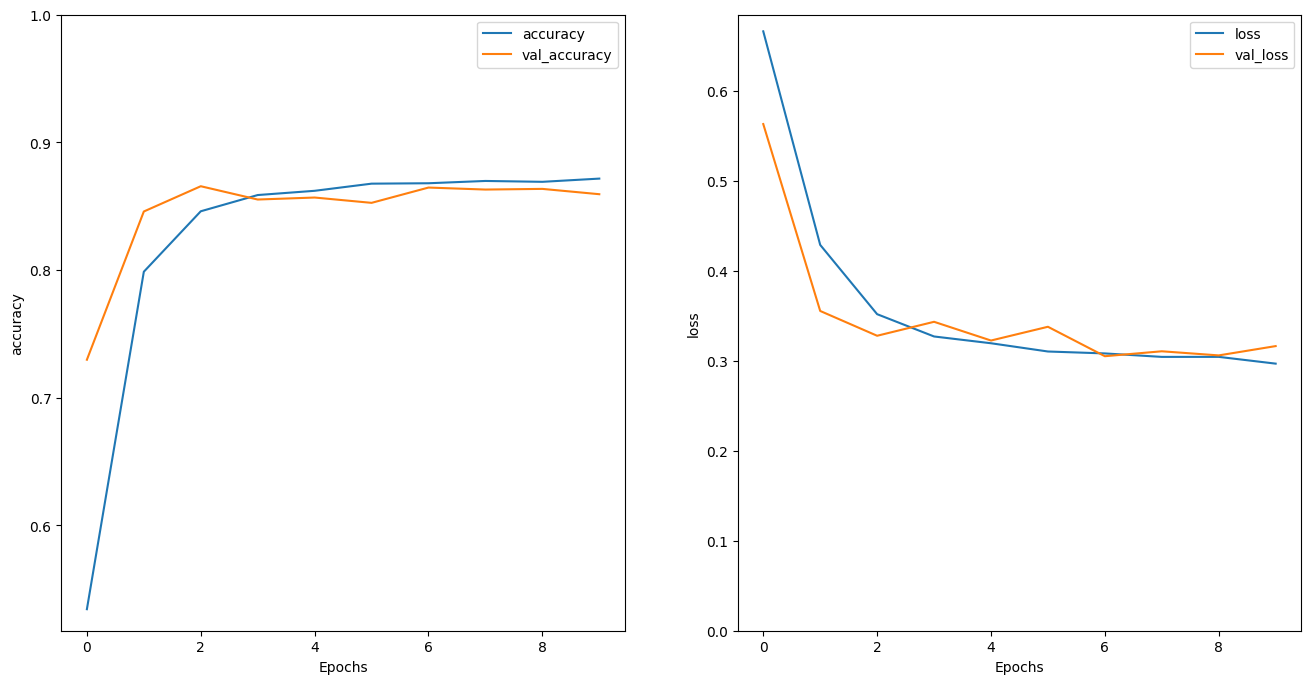

In [126]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Prediction

In [140]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
input_text = tf.constant([sample_text])
predictions = model.predict(input_text)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.79070127]
